In [11]:
using LinearAlgebra, Zygote

In [1]:
camfile = open("demo/7cams.txt")
Cpams = Array{Array{Float64, 1}, 1}(undef, 0)
for line in eachline(camfile)
    parts = filter(s -> !isempty(s), split(line, " "))
    c = parse.(Float64, parts)
    push!(Cpams, c)
end

# from calibration file
const CMATRIX = [
    851.57945 0.0 330.24755 0.0
    0.0 853.01905 262.19500 0.0
    0.0 0.0 1.0 0.0
]

3×4 Array{Float64,2}:
 851.579    0.0    330.248  0.0
   0.0    853.019  262.195  0.0
   0.0      0.0      1.0    0.0

In [2]:
ptsfile = open("demo/7pts.txt")
readline(ptsfile)
pointlists = []
Xpams = Array{Array{Float64, 1}, 1}(undef, 0)

for line in eachline(ptsfile)
    parts = filter(s -> !isempty(s), split(line, " "))
    pt3d = parse.(Float64, parts[1:3])
    nframes = parse(Int, parts[4])
    idx = 5
    #println(line)
    points = []
    for i = 1:nframes
        frame = parse(Int, parts[idx])
        x, y = parse.(Float64, parts[idx+1:idx+2])
        idx += 3
        push!(points, (frame, x, y))
    end
    push!(pointlists, points)
    push!(Xpams, pt3d)
end
nviews = 7
npts = length(pointlists)
Y = Array{Array{Float64, 1}, 2}(undef, npts, nviews)
fill!(Y, [0.0, 0.0])
mask = zeros(Int, npts, nviews)
fill!(mask, -1)
for (i, points) in enumerate(pointlists)
    for (f, x, y) in points
        Y[i, f+1] = [x, y]
        mask[i, f+1] = 1
    end
end
mat = mask;

In [3]:
function formAB(n::Int, m::Int, xparams::Int, cparams::Int, X, C, mask)
    #A, B = zeros(2*n, xparams*m), zeros(2*n, cparams*m)
    A = Array{Array{Float64, 2}, 2}(undef, n, m)
    B = Array{Array{Float64, 2}, 2}(undef, n, m)
    for i = 1:n
        for j = 1:m
            if mask[i,j] == -1
                A[i,j] = zeros(2, cparams)
                B[i,j] = zeros(2, xparams)
            else
                # compute Jacobian blocks A_ij and B_ij
                x, c = X[i], C[j]
                JQ = Q_jacobian([x ; c])
                Jx = JQ[:, 1:xparams]
                Jc = JQ[:, xparams+1:xparams+cparams]
                A[i,j] = Jc
                B[i,j] = Jx
            end
        end
    end
    return A, B
end

formAB (generic function with 1 method)

In [4]:
function formUVWZ(n::Int, m::Int, xparams::Int, cparams::Int, A, B, λ::Float64)
    U = Array{Array{Float64, 2}, 1}(undef, m)
    V = Array{Array{Float64, 2}, 1}(undef, n)
    W = Array{Array{Float64, 2}, 2}(undef, n, m)
    Z = Array{Array{Float64, 2}, 2}(undef, n, m)
    for j = 1:m
        U[j] = zeros(cparams, cparams)# + λ*I
        for i = 1:n
            U[j] += A[i,j]'*A[i,j]
        end
        U[j] += λ*I # Diagonal(diag(U[j]) * λ)
    end
    for i = 1:n
        V[i] = zeros(xparams, xparams)# + λ*I
        for j = 1:m
            V[i] += B[i,j]'*B[i,j]
        end
        V[i] += λ*I # Diagonal(diag(V[i]) * λ)
    end
    for i = 1:n
        for j = 1:m
            W[i,j] = A[i,j]'*B[i,j]
        end
    end
    for i = 1:n
        for j = 1:m
            #Z[i,j] = V[i] \ W[i,j]
            Z[i,j] = W[i,j] * inv(V[i])
        end
    end
    return U, V, W, Z
end

formUVWZ (generic function with 1 method)

In [5]:
function formSb(n::Int, m::Int, xparams::Int, cparams::Int, U, Z, W, X, C, Y)
    #S = zeros(n*xparams, n*xparams) # should be m ?
    S = zeros(m*cparams, m*cparams)
    for i = 1:m
        #i1, i2 = 1 + xparams*(i-1), xparams*i
        i1, i2 = 1 + cparams*(i-1), cparams*i
        for j = 1:m
            #j1, j2 = 1 + xparams*(j-1), xparams*j
            j1, j2 = 1 + cparams*(j-1), cparams*j
            
            if i == j
                S[i1:i2, j1:j2] = U[i]
            end
            
            for k = 1:n
                S[i1:i2, j1:j2] -= Z[k, i]*W[k, j]'
            end
        end
    end
    errs = Array{Array{Float64, 1}, 2}(undef, n, m)
    for i = 1:n
        for j = 1:m
            x, c = X[i], C[j]
            obs = Q_project([x ; c])
            errs[i,j] = Y[i,j] - obs
        end
    end
    errs_a = Array{Array{Float64, 1}, 1}(undef, m)
    errs_b = Array{Array{Float64, 1}, 1}(undef, n)
    for j = 1:m
        errs_a[j] = zeros(cparams)
        for i = 1:n
            errs_a[j] += A[i,j]'*errs[i,j]
        end
    end
    for i = 1:n
        errs_b[i] = zeros(xparams)
        for j = 1:m
            errs_b[i] += B[i,j]'*errs[i,j]
        end
    end
    
    b = zeros(m*cparams) # should be m?
    for j = 1:m
        bj = errs_a[j]
        for i = 1:n
            bj -= Z[i,j]*errs_b[i]
        end
        j1, j2 = 1 + cparams*(j-1), cparams*j
        b[j1:j2] = bj
    end
    
    return S, b, errs_a, errs_b
end

formSb (generic function with 1 method)

In [6]:
function formDelB(n::Int, m::Int, xparams::Int, cparams::Int, V, W, errs_b, δ_a)
    δ_b = Array{Array{Float64, 1}, 1}(undef, n)
    for i = 1:n
        inner = errs_b[i]
        for j = 1:m
            inner -= W[i,j]'*δ_a[j]
        end
        δ_b[i] = inv(V[i]) * inner # (V[i] \ inner)
    end
    return δ_b
end

formDelB (generic function with 1 method)

In [7]:
function groupDelA(m::Int, cparams::Int, δ_a)
    grouped = Array{Array{Float64, 1}, 1}(undef, m)
    for j = 1:m
        j1, j2 = 1 + (j-1)*cparams, j*cparams
        grouped[j] = δ_a[j1:j2]
    end
    return grouped
end

groupDelA (generic function with 1 method)

In [8]:
function Q_project(params)
    xyz = params[1:3]
    θ, u₁, u₂, u₃ = params[4:7]
    t = params[8:10]
    c, s = cos(θ/2), sin(θ/2)
    a, b, c, d = c, u₁*s, u₂*s, u₃*s
    T = [
        a^2+b^2-c^2-d^2  2b*c-2a*d        2b*d+2a*c       0
        2b*c+2a*d        a^2-b^2+c^2-d^2  2c*d-2a*b       0
        2b*d-2a*c        2c*d+2a*b        a^2-b^2-c^2+d^2 0
        0 0 0 1
    ]
    #coord = C * T * ([xyz ; 1] + [t ; 0])
    coord = CMATRIX * T *( [xyz ; 1] + [t ; 0])
    return coord[1:2] ./ coord[3]
end

function Q_jacobian(params)
    Zygote.forward_jacobian(Q_project, params)[2]'
end

Q_jacobian (generic function with 1 method)

In [9]:
function computeUpdate(npts, nviews, nxp, ncp, Xpams, Cpams, mat, λ)
    A, B = formAB(npts, nviews, nxp, ncp, Xpams, Cpams, mat)
    U, V, W, Z = formUVWZ(npts, nviews, nxp, ncp, A, B, λ)
    S, b, errs_a, errs_b = formSb(npts, nviews, nxp, ncp, U, Z, W, Xpams, Cpams, Y)
    δ_a = S \ b
    δ_a_group = groupDelA(nviews, ncp, δ_a)
    δ_b_group = formDelB(npts, nviews, nxp, ncp, V, W, errs_b, δ_a_group)
    return δ_a_group, δ_b_group, errs_a, errs_b
end

computeUpdate (generic function with 1 method)

In [12]:
nxp = 3
ncp = 7

errs_old = []
for i = 1:npts
    for j = 1:nviews
        if mask[i,j] != -1
            x, c = Xpams[i], Cpams[j]
            obs = Q_project([x ; c])
            res = Y[i,j] - obs
            push!(errs_old, res)
        end
    end
end
preverr = norm(errs_old)

ν = 2

A, B = formAB(npts, nviews, nxp, ncp, Xpams, Cpams, mask)
U, V, W, Z = formUVWZ(npts, nviews, nxp, ncp, A, B, 0.0)
m1 = maximum( [maximum(diag(u)) for u in U] )
m2 = maximum( [maximum(diag(v)) for v in V] )
mm = max(m1, m2)
println("------------------ ", mm)
println("================== ", preverr)

λ = 1e-2 * mm
#λ2 = λ
errz = [preverr]
for k = 1:100
    #λ2 = 8e-4 * mm
    δ_C, δ_X, errs_a, errs_b = computeUpdate(npts, nviews, nxp, ncp, Xpams, Cpams, mask, λ)
    
    err = 0.0
    errs = []
    for i = 1:npts
        for j = 1:nviews
            if mask[i,j] != -1
                x, c = Xpams[i]+δ_X[i], Cpams[j]+δ_C[j]
                obs = Q_project([x ; c])
                res = Y[i,j] - obs
                push!(errs, res)
            end
        end
    end
    err = norm(errs)
    denom = 0.0
    maxpc, maxpx = 0.0, 0.0
    maxupdatec, maxupdatex = 0.0, 0.0
    for j = 1:nviews
        denom += δ_C[j]' * (λ*δ_C[j] + errs_a[j])
        maxupdatec = max(maxupdatec, maximum(abs.(δ_C[j])))
        maxpc = max(maxpc, maximum(abs.(Cpams[j])))
    end
    for i = 1:npts
        denom += δ_X[i]' * (λ*δ_X[i] + errs_b[i])
        maxupdatex = max(maxupdatex, maximum(abs.(δ_X[i])))
        maxpx = max(maxpx, maximum(abs.(Xpams[i])))
    end
    rho = (preverr^2 - err^2) / denom

    if rho > 0
        factor = max(1/3, 1 - (2rho-1)^2)
        λ *= 0.3 # factor
        ν = 2
        
        for i = 1:npts
            Xpams[i] += δ_X[i]
        end
        for j = 1:nviews
            Cpams[j] += δ_C[j]
        end
        push!(errz, err)
        preverr = err
    else
        push!(errz, preverr)
        println("bad ")
        λ *= ν
        ν *= 2
    end
    maxpc, maxpx = sqrt(maxpc), sqrt(maxpx)
    maxupatec, maxupdatex = sqrt(maxupdatec), sqrt(maxupdatex)
    println("[$k] ########## $maxupdatec / $maxupdatex  ~~ $maxpc / $maxpx")
    println("[$k] @@@@@@@@@@ ", λ, " / ", err, " / ", preverr)
end

------------------ 1.0604037024481063e12
================== 3556.6052537568416
[1] ########## 0.0025961853428604384 / 0.020877312374633944  ~~ 1.0 / 0.14467204291085406
[1] @@@@@@@@@@ 3.181211107344319e9 / 666.7463089691088 / 666.7463089691088
[2] ########## 0.0016899207436342322 / 0.021957368865846837  ~~ 1.0 / 0.144793250776543
[2] @@@@@@@@@@ 9.543633322032956e8 / 317.7357488682677 / 317.7357488682677
[3] ########## 0.0004329524754166456 / 0.021613358496047407  ~~ 1.000000000374823 / 0.14536139508719909
[3] @@@@@@@@@@ 2.863089996609887e8 / 221.71118657306107 / 221.71118657306107
[4] ########## 0.0006608039008271518 / 0.023911186281895376  ~~ 0.9999999966080778 / 0.1459031237404051
[4] @@@@@@@@@@ 8.589269989829661e7 / 163.52587760595003 / 163.52587760595003
[5] ########## 0.0014786203183901896 / 0.028401278690009128  ~~ 0.9999999086501236 / 0.14684819255362982
[5] @@@@@@@@@@ 2.5767809969488982e7 / 126.22129212471683 / 126.22129212471683
[6] ########## 0.0031375116084764888 / 0.0314623

bad 
[46] ########## 0.005535250016539938 / 0.036549696687396264  ~~ 0.9992917862623029 / 0.14105934905881437
[46] @@@@@@@@@@ 694600.3051454248 / 66.11419690978467 / 37.85099288187086
bad 
[47] ########## 0.002812915059153564 / 0.0258024318066206  ~~ 0.9992917862623029 / 0.14105934905881437
[47] @@@@@@@@@@ 2.778401220581699e6 / 39.9529352186901 / 37.85099288187086
bad 
[48] ########## 0.0006759630098755312 / 0.012753070705598465  ~~ 0.9992917862623029 / 0.14105934905881437
[48] @@@@@@@@@@ 2.2227209764653593e7 / 37.88469896804944 / 37.85099288187086
[49] ########## 7.925684873648624e-5 / 0.004793164094278262  ~~ 0.9992917862623029 / 0.14105934905881437
[49] @@@@@@@@@@ 6.668162929396078e6 / 37.822161210358814 / 37.822161210358814
[50] ########## 0.00018004725130289635 / 0.0061270655881688375  ~~ 0.9992924624100435 / 0.1409778902341135
[50] @@@@@@@@@@ 2.0004488788188233e6 / 37.79583054512941 / 37.79583054512941
[51] ########## 0.0003480842497896091 / 0.008513335656465358  ~~ 0.99929364151

[90] ########## 0.0001327024850192397 / 0.0062277640280642655  ~~ 0.999235408888056 / 0.13984559135323404
[90] @@@@@@@@@@ 718991.3323642504 / 36.71608473752791 / 36.71608473752791
[91] ########## 0.0006596330212853709 / 0.008202149242953795  ~~ 0.9992360935183265 / 0.1397379935034186
[91] @@@@@@@@@@ 215697.39970927514 / 36.6720805347967 / 36.6720805347967
bad 
[92] ########## 0.005753604048011946 / 0.015903288939808254  ~~ 0.9992348950395235 / 0.1395135660300828
[92] @@@@@@@@@@ 431394.7994185503 / 37.26651984222323 / 36.6720805347967
[93] ########## 0.0031223797715576322 / 0.011270237733559679  ~~ 0.9992348950395235 / 0.1395135660300828
[93] @@@@@@@@@@ 129418.43982556507 / 36.562896283940084 / 36.562896283940084
bad 
[94] ########## 0.045823942574635186 / 0.07256217184118723  ~~ 0.9992101377918446 / 0.1397402227282572
[94] @@@@@@@@@@ 258836.87965113015 / 9699.5166599866 / 36.562896283940084
bad 
[95] ########## 0.02600838091644925 / 0.05138990568554806  ~~ 0.9992101377918446 / 0.139740

In [ ]:
import PyPlot
xs, ys = [], []
cam = 4
for i = 1:npts
    if mask[i, cam] != -1
        push!(xs, Y[i, cam][1])
        push!(ys, Y[i, cam][2])
    end
end
PyPlot.scatter(xs, ys)

xs, ys = [], []
for i = 1:npts
    if mask[i, cam] != -1
        xx = Xpams[i]
        cc = Cpams[cam]
        pt = Q_project([xx ; cc])
        push!(xs, pt[1])
        push!(ys, pt[2])
    end
end
PyPlot.scatter(xs, ys)
PyPlot.title("Frame $cam")

In [178]:
using SparseArrays
A, B = formAB(npts, nviews, nxp, ncp, Xpams, Cpams, mat)
U, V, W, Z = formUVWZ(npts, nviews, nxp, ncp, A, B, 10.0)

JTJ = spzeros(nviews*ncp+npts*nxp, nviews*ncp+npts*nxp)
for j = 1:nviews
    j1, j2 = 1+(j-1)*ncp, j*ncp
    JTJ[j1:j2,j1:j2] = U[j]
end
for i = 1:npts
    i1, i2 = 1+(i-1)*nxp, i*nxp
    JTJ[i1:i2,i1:i2] = V[i]
end
for i = 1:npts
    for j = 1:nviews
        i1, i2 = nviews*ncp + 1 + (i-1)*nxp, nviews*ncp + i*nxp
        j1, j2 = 1+(j-1)*ncp, j*ncp
        JTJ[i1:i2,j1:j2] = W[i,j]'
    end
end
for i = 1:npts
    for j = 1:nviews
        i1, i2 = nviews*ncp + 1 + (i-1)*nxp, nviews*ncp + i*nxp
        j1, j2 = 1+(j-1)*ncp, j*ncp
        JTJ[j1:j2,i1:i2] = W[i,j]
    end
end

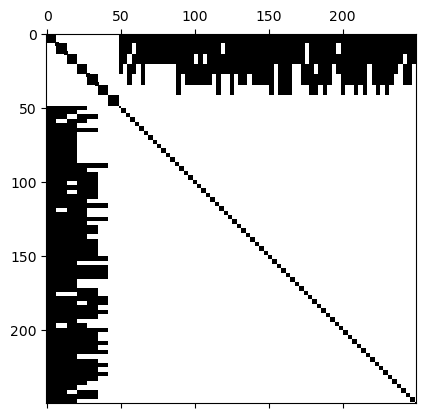

PyObject <matplotlib.image.AxesImage object at 0x1a86e7a50>

In [180]:
PyPlot.spy(JTJ[1:250,1:250])
#PyPlot.spy(JTJ)

In [4]:
import NLopt
function sqerror(P::Vector)
    ofs = npts*3 # nviews*7
    err = 0.0
    for i = 1:npts
        i1, i2 = 1+3*(i-1), 3*i
        pt = P[i1:i2]
        for j = 1:nviews
            j1, j2 = 1+7*(j-1), 7*j
            cam = P[ofs+j1:ofs+j2]
            if mask[i,j] != -1
                r = Y[i,j] - Q_project([pt ; cam])
                err += r[1]^2 + r[2]^2
            end
        end
    end
    return sqrt(err)
end

sqerror (generic function with 1 method)

In [45]:
dim = npts*3 + nviews*7
errorlist = []
function myfunc(P::Vector, grad::Vector)
    err = sqerror(P)
    grad[1:dim] = gradient(sqerror, P)[1]
    println("err ", err)
    push!(errorlist, err)
    return err
end

P = zeros(dim)
for i = 1:npts
    i1, i2 = 1+3*(i-1), 3*i
    P[i1:i2] = Xpams[i]
end
for j = 1:nviews
    j1, j2 = 1+7*(j-1), 7*j
    ofs = npts*3
    P[ofs+j1:ofs+j2] = Cpams[j]
end
sqerror(P)

3556.605253756841

In [46]:
opt = NLopt.Opt(:LD_MMA, dim)
opt.xtol_rel = 1e-4
opt.maxeval = 200
opt.min_objective = myfunc
(minf,minx,ret) = NLopt.optimize(opt, P)

>>>>>> err 3556.605253756841
>>>>>> err 235552.6261824882
>>>>>> err 240953.63875361948
>>>>>> err 213289.8859332985
>>>>>> err 3.9203087117940327e6
>>>>>> err 4.377177919536294e6
>>>>>> err 380554.29863346816
>>>>>> err 425790.1168508273
>>>>>> err 195616.850474818
>>>>>> err 488292.301246441
>>>>>> err 433155.257124656
>>>>>> err 1.4017849043078069e6


(3556.605253756841, [8.9e-5, 0.00149, 0.010242, -0.000348, 0.001472, 0.010205, -0.000871, 0.001475, 0.010553, -0.000726  …  0.008776, -0.000225, 0.000534, 0.983731, -0.008923, -0.16478, -0.071003, 0.011102, -0.000145, 0.000869], :FAILURE)

In [16]:
function rollingmin(list)
    m = Inf
    newlist = []
    for x in list
        if x < m
            m = x
        end
        push!(newlist, m)
    end
    return newlist
end

rollingmin (generic function with 1 method)

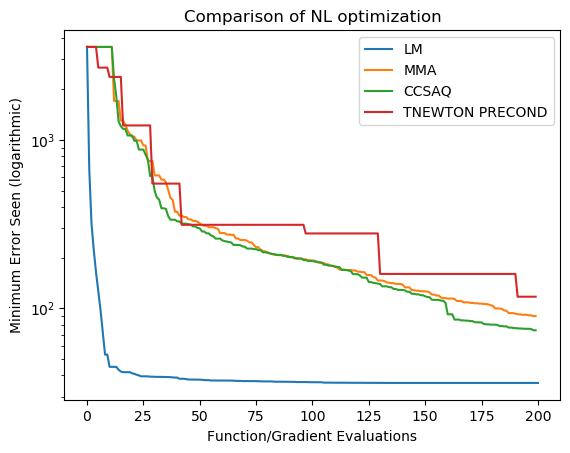

PyObject <matplotlib.legend.Legend object at 0x194a015d0>

In [57]:
import PyPlot
PyPlot.semilogy(errz, label="LM")
PyPlot.semilogy(rollingmin(errlist_ld_mma), label="MMA")
PyPlot.semilogy(rollingmin(errlist_ld_ccsaq), label="CCSAQ")
PyPlot.semilogy(rollingmin(errlist_LD_TNEWTON_PRECOND[1:200]), label="TNEWTON PRECOND")
PyPlot.xlabel("Function/Gradient Evaluations")
PyPlot.ylabel("Minimum Error Seen (logarithmic)")
PyPlot.title("Comparison of NL optimization")
PyPlot.legend()